## Dynamic programming

### Assigment for 8/6/2021 - Economic Growth
_Junghanss, Juan Cruz ; Marco, Tomas Guido ; Freysselinard, Pedro_

### Example
#### Optimal Growth
Let's start by computing the solution to an optimal growth problem, in which a social planner seeks to find paths $\left\{c_{t}, k_{t}\right\}$ such that
$$
\begin{array}{rr}
\left\{c_{t}, k_{t}\right\} & \sum_{t=0}^{\infty} \beta^{t} u\left(c_{t}\right) \\
k_{t+1} \leq f\left(k_{t}\right)+(1-\delta) k_{t}-c_{t} \\
0, & k_{t} \geq 0, k_{0} \text { is given }
\end{array}
$$

An example with analytical solution
Let's assume that $u(c)=\ln (c), f(k)=k^{\alpha}$, and $\delta=1 .$ For this case we have seen that the solution implies Optimal Con:

$$
\begin{array}{cr}
\text { Value Function: } V(k)= & \frac{\ln (1-\alpha \beta)}{1-\beta}+\frac{\alpha \beta \ln (\alpha \beta)}{(1-\alpha \beta)(1-\beta)}+\frac{\alpha}{1-\alpha \beta} \ln (k) \\
\text { Optimal Policy: } \pi(k)= & \beta \alpha k^{\alpha} \\
\text { Consumption Function: } c= & (1-\beta \alpha) k^{\alpha}
\end{array}
$$
into the cell below and define Python functions for the actual optimal solutions given above

In [1]:
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
# We define our parameters
A=3.0
alpha=0.45
beta=0.8
tol=1e-3
delta = 1
sigma = 1

In [3]:
# Grid of values for state variable over which function will be approximated
gridmin, gridmax, gridsize = 0.1, 30, 300
grid = np.linspace(gridmin, gridmax**1e-1, gridsize)**10

#### Here we have created a grid on $[gridmin,gridmax]$ that has a number of points given by gridsize. Since we know that the Value functions is stricly concave, our grid has more points closer to zero than farther away

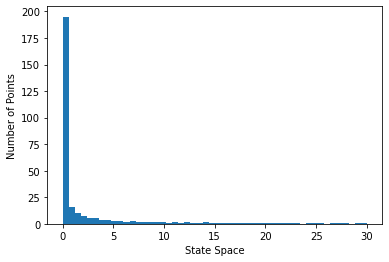

In [4]:
plt.hist(grid, bins=50);
plt.xlabel('State Space');
plt.ylabel('Number of Points');

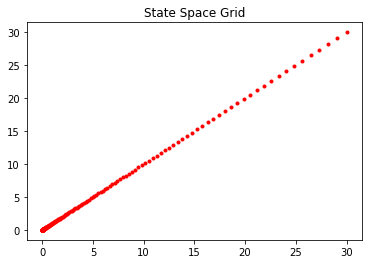

In [5]:
plt.plot(grid, grid,'r.');
plt.title('State Space Grid');

### Define our functions

In [6]:
# Utility Function
def U(c, sigma=1):
    '''This function returns the value of utility when the CRRA
    coefficient is sigma. I.e. 
    u(c,sigma)=(c**(1-sigma)-1)/(1-sigma) if sigma!=1 
    and 
    u(c,sigma)=ln(c) if sigma==1
    Usage: u(c,sigma)
    '''
    if sigma!=1:
        u = (c**(1-sigma)-1) / (1-sigma)
    else:
        u = np.log(c)
    return u


# Production Function
def F(K, L=1, alpha=.45, A=1):
    '''
    Cobb-Douglas production function
    F(K,L)=K^alpha L^(1-alpha)
    '''
    return A * K**alpha * L**(1-alpha)

#### We have to either replace our objective function for its negative or, better yet, define a function that uses fminbound and returns the maximum and the maximizer

In [7]:
# Maximize function V on interval [a,b]
def maximum(V, a, b, **kwargs):
    return float(V(sp.optimize.fminbound(lambda x: -V(x), a, b, **kwargs)))

# Return Maximizer of function V on interval [a,b]
def maximizer(V, a, b, **kwargs):
    return float(sp.optimize.fminbound(lambda x: -V(x), a, b, **kwargs))

In [8]:
# Interpolation mechanism
class LinInterp:
    "Provides linear interpolation in one dimension."

    def __init__(self, X, Y):
        """Parameters: X and Y are sequences or arrays
        containing the (x,y) interpolation points.
        """
        self.X, self.Y = X, Y

    def __call__(self, z):
        """Parameters: z is a number, sequence or array.
        This method makes an instance f of LinInterp callable,
        so f(z) returns the interpolation value(s) at z.
        """
        if isinstance(z, int) or isinstance(z, float):
            return np.interp ([z], self.X, self.Y)[0]  
        else:
            return np.interp(z, self.X, self.Y)

In [9]:
# The following two functions are used to find the optimal policy and value functions using value function iteration
# Bellman Operator
def bellman(w):
    """The approximate Bellman operator.
    Parameters: w is a LinInterp object (i.e., a 
    callable object which acts pointwise on arrays).
    Returns: An instance of LinInterp that represents the optimal operator.
    w is a function defined on the state space.
    """
    vals = []
    for k in grid:
        kmax = F(k, alpha=alpha) + (1-delta) * k
        h = lambda kp: U(kmax - kp, sigma) + beta * w(kp)
        vals.append(maximum(h, 0, kmax))
    return LinInterp(grid, vals)

In [10]:
# Optimal policy
def policy(w):
    """
    For each function w, policy(w) returns the function that maximizes the 
    RHS of the Bellman operator.
    Replace w for the Value function to get optimal policy.
    The approximate optimal policy operator w-greedy (See Stachurski (2009)). 
    Parameters: w is a LinInterp object (i.e., a 
    callable object which acts pointwise on arrays).
    Returns: An instance of LinInterp that captures the optimal policy.
    """
    vals = []
    for k in grid:
        kmax = F(k,alpha=alpha) + (1-delta) * k
        h = lambda kp: U(kmax - kp,sigma) + beta * w(kp)
        vals.append(maximizer(h, 0, kmax))
    return LinInterp(grid, vals)

In [11]:
# Parameters for the optimization procedures
count = 0
maxiter = 1000
tol = 1e-6
print('tol=%f' % tol)

tol=0.000001


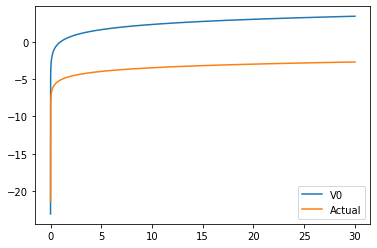

In [12]:
# def Va(k, alpha=.45, beta=.8):
#     ab = alpha*beta
#     F=alpha/(1-alpha*beta)
#     E= np.log(A/(1+beta*F)*(beta*F*A/(1+beta*F))**(beta*F))/(1-beta)
#     return E+F*np.log(k)

def Va(k, alpha=.45, beta=.8):
    ab = alpha*beta
    return np.log(1-ab) / (1-beta) + ab * np.log(ab) / ((1-beta) * (1-ab)) + alpha * np.log(k) / (1-ab)


V0 = LinInterp(grid,U(grid))
plt.figure(1)
plt.plot(grid, V0(grid), label='V'+str(count));
plt.plot(grid, Va(grid), label='Actual');
plt.legend(loc=0);

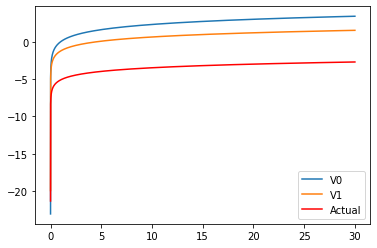

In [13]:
plt.plot(grid, V0(grid), label='V'+str(count));
count += 1
V0 = bellman(V0)
plt.figure(1)
plt.plot(grid, V0(grid), label='V'+str(count));
plt.plot(grid, Va(grid), label='Actual',color='r');
plt.legend(loc=0);
plt.show();

#### Automating the process

110


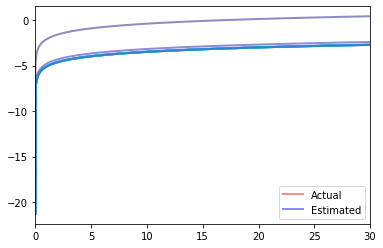

In [14]:
fig, ax = plt.subplots()
ax.set_xlim(grid.min(), grid.max())
ax.plot(grid, Va(grid), label='Actual', color='r', lw=2, alpha=0.45);

count=0
maxiter=200
tol=1e-6
while count<maxiter:
    V1 = bellman(V0)
    err = np.max(np.abs(np.array(V1(grid))-np.array(V0(grid))))
    if np.mod(count,10)==0:
        ax.plot(grid, V1(grid), color=plt.cm.jet(count / maxiter), lw=2, alpha=0.45);
        #print('%d %2.10f ' % (count,err))
    V0 = V1
    count += 1
    if err<tol:
        print(count)
        break
ax.plot(grid, V1(grid), label='Estimated', color='b', lw=2, alpha=0.45);
ax.legend(loc='lower right')
plt.draw();

1.8845223159758007e-07
0.0028753236374665647


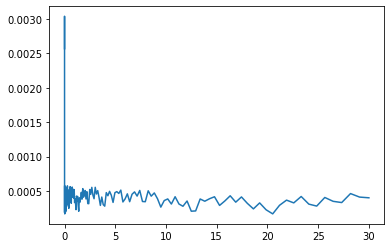

In [15]:
print(err)
err = Va(grid)-V1(grid)
plt.plot(grid,err);
print(err.max()-err.min())

### Homework 1

1. Use the policy function to compute the optimal policy. Compare it to the actual one
2. Do the same for the consumption function. Find the savings rate and plot it.
3. Construct the paths of consumption and capital starting from $k_0=.1$. Show the time series and the paths in the consumption-capital space
4. Estimate the level of steady state capital and consumption. Show graphically that it is lower than the Golden Rule Level.

In [16]:
# Styling & our Default Parameters of Matplotlib

%matplotlib inline
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title

plt.style.use('seaborn') 

In [17]:
def ActualOptimalK(k, alpha=.45, beta=.8):
    return alpha * beta * k**alpha

def ActualOptimalConsumption(k, alpha=.45, beta=.8):
    return (1-alpha*beta)*k**alpha

#### 1. Since we already have V1, we can just apply policy(V1) to get the result

In [18]:
EstimatedOptimalK = policy(V1)

Text(0, 0.5, 'Capital')

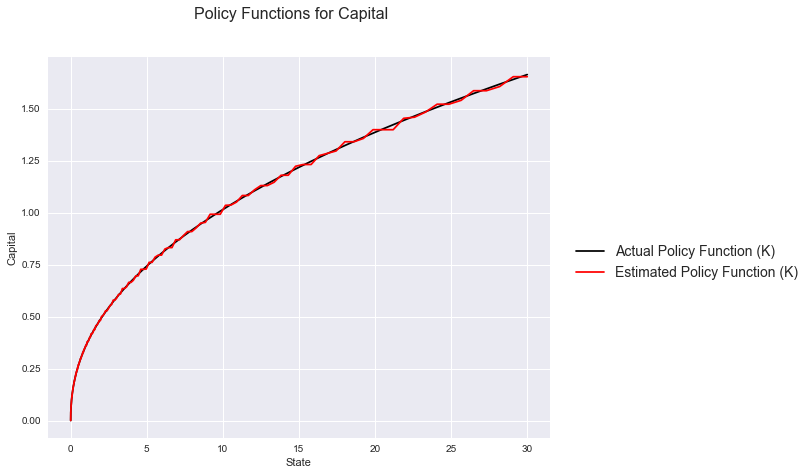

In [19]:
plt.figure(1, figsize=(9,7))
plt.plot(grid, ActualOptimalK(grid), label='Actual Policy Function (K)', color = 'k')
plt.plot(grid, EstimatedOptimalK(grid), label='Estimated Policy Function (K)', color = 'r')
plt.legend(loc=(1.04,0.4), fontsize=14)
plt.suptitle('Policy Functions for Capital')
plt.xlabel('State')
plt.ylabel('Capital')

#### 2. Use the policy function to compute consumption:

Since we know from our budget constraint that $c=f(k_t)+(1-\delta)k_t-k_{t+1}$, we can rewrite our equation for consumption like that in Python:

In [20]:
def EstimatedOptimalConsumption(k):
    c = F(k) + (1-delta)*k - EstimatedOptimalK(k)

    return c

Recall that the Actual Optimal Consumption is $c=(1-\alpha\beta)\cdot k^{\alpha}$ and we compare it on the plot

Text(0, 0.5, 'Consumption')

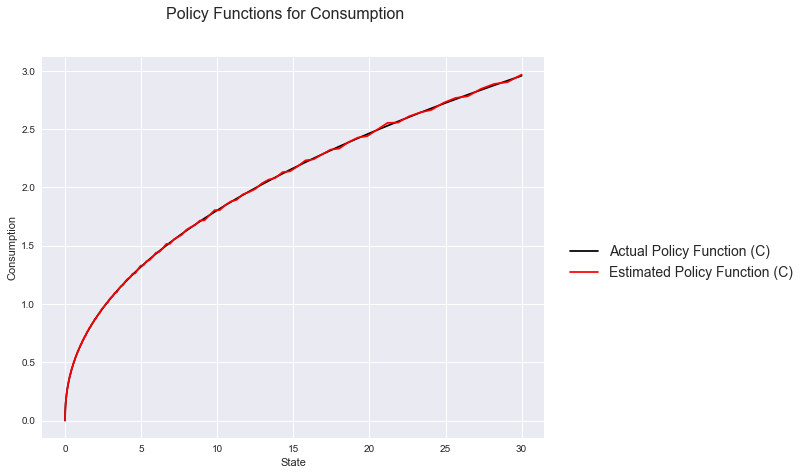

In [21]:
plt.figure(1, figsize=(9,7))
plt.plot(grid, ActualOptimalConsumption(grid), label='Actual Policy Function (C)', color = 'k')
plt.plot(grid, EstimatedOptimalConsumption(grid), label='Estimated Policy Function (C)', color = 'r')
plt.legend(loc=(1.04,0.4), fontsize=14)
plt.suptitle('Policy Functions for Consumption')
plt.xlabel('State')
plt.ylabel('Consumption')

#### Find the savings rate and plot it.

Savings are $s = f(k)-c^*$, where we'll be using $c^*$ from our previous functions.

In [22]:
def EstimatedOptimalSavings(k):
    s = F(k) - EstimatedOptimalConsumption(k)
    return s

def ActualOptimalSavings(k):
    s = F(k) - ActualOptimalConsumption(k)
    return s

Text(0, 0.5, 'Savings')

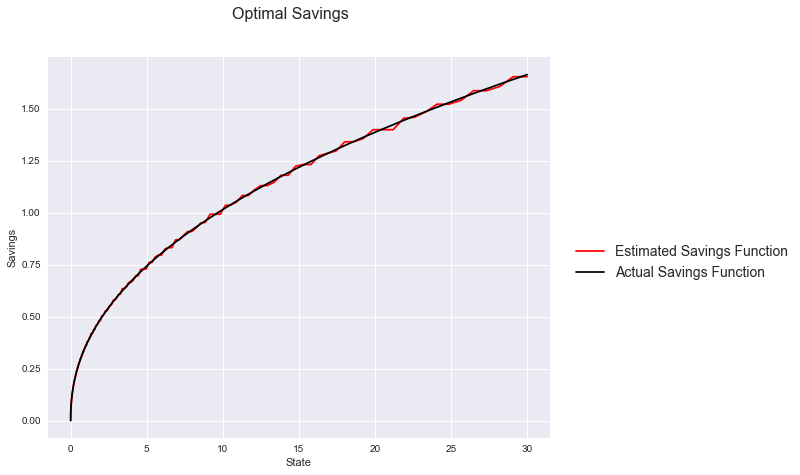

In [23]:
plt.figure(1, figsize=(9,7))
plt.plot(grid, EstimatedOptimalSavings(grid), label='Estimated Savings Function', color = 'r')
plt.plot(grid, ActualOptimalSavings(grid), label='Actual Savings Function', color ='k')
plt.legend(loc=(1.04,0.4), fontsize=14)
plt.suptitle('Optimal Savings')
plt.xlabel('State')
plt.ylabel('Savings')

#### 3. Time paths for consumption and capital starting from $k_0$ = 1

Capital Values: 
 [0.1, 0.1291547604455499, 0.14401465532748423, 0.15182775821169534, 0.15319770210222386, 0.15319819277646282, 0.15319823641773184, 0.1531982642790812, 0.1531982820662539, 0.15319829342189603, 0.15319830067153656, 0.15319830529983386, 0.1531983082546198, 0.15319831014100682, 0.15319831134530928, 0.15319831211415705, 0.1531983126050029, 0.1531983129183675, 0.1531983131184249, 0.15319831324614508] 
 
 Consumption Values: 
 [0.22565862878802556, 0.25409222940988696, 0.2662749784519569, 0.27496420956762, 0.27669791491602747, 0.2766984908822366, 0.2766985181296102, 0.2766985355248055, 0.27669854663020055, 0.27669855372007823, 0.27669855824637984, 0.27669856113604985, 0.2766985629808656, 0.27669856415862826, 0.2766985649105326, 0.27669856539056137, 0.27669856569702017, 0.27669856589266884, 0.2766985660175743, 0.27669856609731625]


Text(0, 0.5, 'Units')

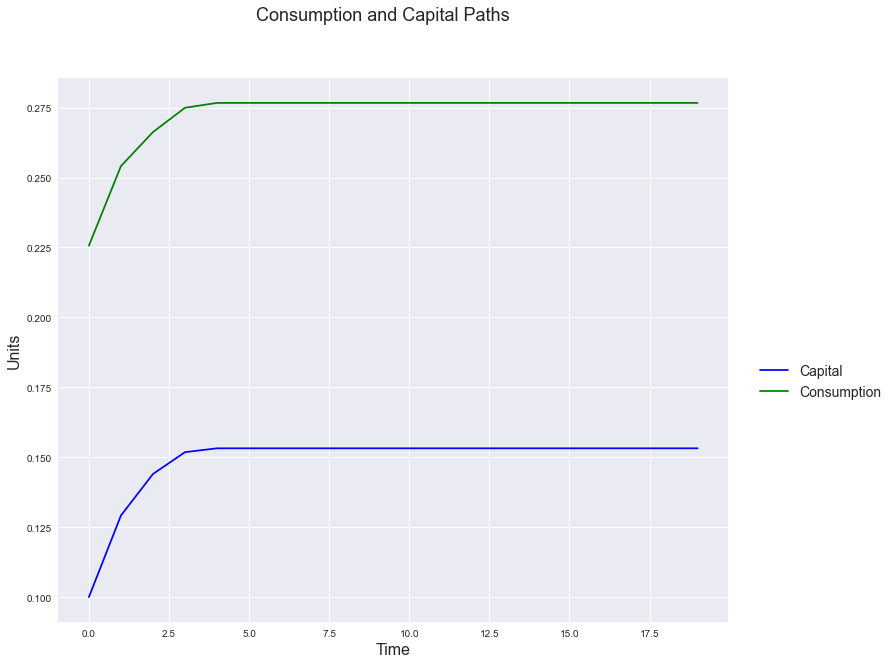

In [24]:
Time = np.arange(20)  # Array for time
kt = []  # List for Capital Values
ct = []  # List for Consumption values
kt0 = 0.1  # Starting value for capital k_t0


for t in range(0, len(Time)):
    kt.append(kt0)
    c0 = EstimatedOptimalConsumption(kt0)
    ct.append(c0)
    kt0 = EstimatedOptimalK(kt0)
    

print('Capital Values: \n',kt, '\n \n Consumption Values: \n',ct) # Print to check

plt.figure(1, figsize=(12,10))
plt.plot(Time,kt, label='Capital', color = 'b')
plt.plot(Time,ct, label='Consumption', color = 'g')
plt.legend(loc=(1.04,0.4), fontsize=14)
plt.suptitle('Consumption and Capital Paths', fontsize = 18)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Units', fontsize=16)

#### 4. Estimate the level of steady state capital and consumption. Show graphically that it is lower than the Golden Rule Level.

As we can see from previous values of our $K_t$ list, steady state is around $0.153198$, where the values converged and rarely differ from period to period. Therefore, we can use our last value of the list as a reference.

Same for consumption, the value is $0.27669$.

In [25]:
print('Steady state of Capital k(t) is: ', kt[19])
print('Steady state of Consumption c(t) is: ', ct[19])

Steady state of Capital k(t) is:  0.15319831324614508
Steady state of Consumption c(t) is:  0.27669856609731625


The Solow Golden Rule in the Solow Model is derived as follows: since consumption is the difference between output and investment, we can obtain $k^g$ by maximizing $c$ in terms of $k$.



\begin{align}
 c&= Ak^{\alpha} - (\delta + n)k^g                                            \\
 \frac{\partial c}{\partial k} &= \alpha A k^{\alpha - 1} - (\delta + n) = 0  \\
 k^g &= \left( \frac{\alpha A}{\delta + n} \right)^{\frac{1}{1-\alpha}}
\end{align}

We'll use that expression of Capital for our values list

In [26]:
# Estimation of the Golden Rule

periods = 30
kt_gold = [0.1]
ct_gold = []
n = 0

# Iteration through the periods and filling of the lists with values

for t in range(0, periods):
    c0 = F(kt0) - EstimatedOptimalSavings(kt0)*F(kt0)
    ct_gold.append(c0)
    kt0 = ((EstimatedOptimalSavings(kt0) * A) / delta + n)**(1 / (1-alpha))  # 
    kt_gold.append(kt0)


print("Solow Golden Rule Value for Capital is: ", kt_gold[-1])
print("Solow Golden Rule Value for Consumption is: ", ct_gold[-1])

Solow Golden Rule Value for Capital is:  1.9446048463110885
Solow Golden Rule Value for Consumption is:  0.700680864040297


As we can see, both Golden Rule Values (of Solow Model) are higher than actual steady state values from our model.


$k^{gold}>k^{ss} \rightarrow 1.944> 0.15$


$c^{gold}>c^{ss} \rightarrow 0.70> 0.27$

Text(0, 0.5, 'Units')

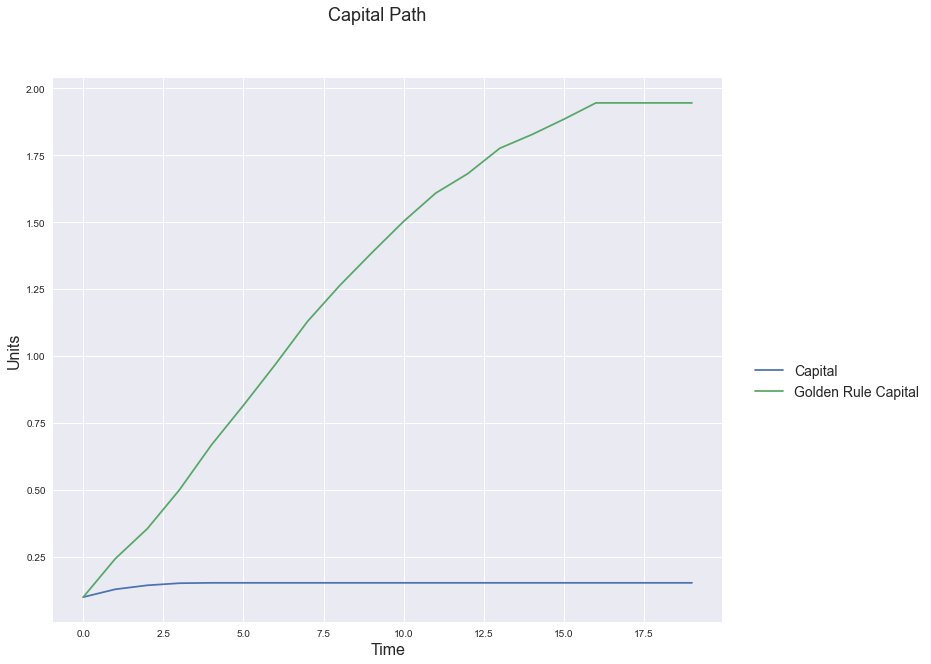

In [28]:
plt.figure(1, figsize=(12,10))
plt.plot(Time,kt, label='Capital')
plt.plot(Time,kt_gold[0:20], label='Golden Rule Capital')
plt.legend(loc=(1.04,0.4), fontsize=14)
plt.suptitle('Capital Path', fontsize = 18)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Units', fontsize=16)

Text(0, 0.5, 'Units')

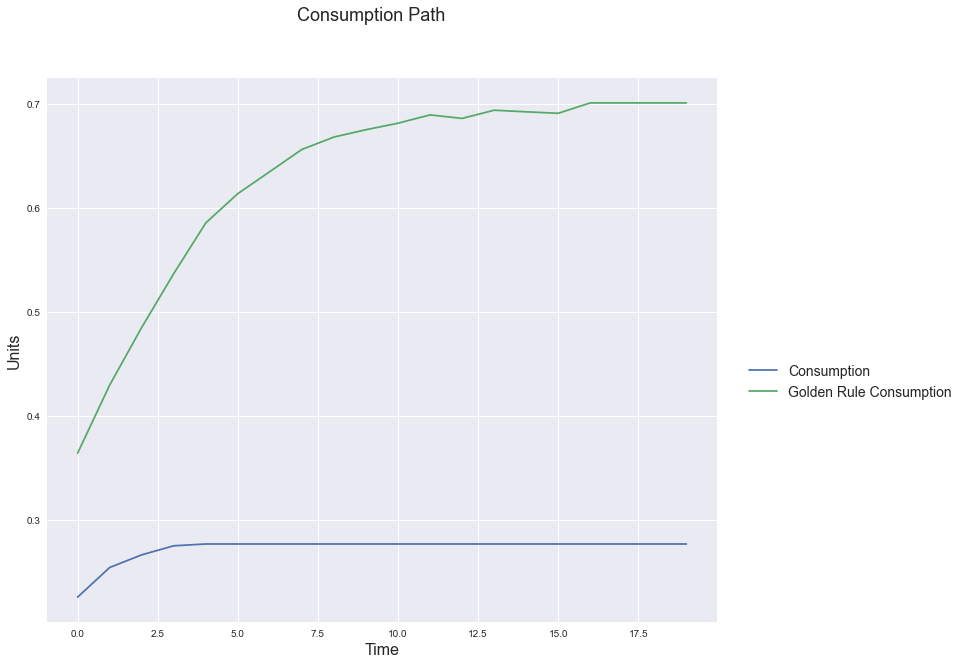

In [29]:
plt.figure(1, figsize=(12,10))
plt.plot(Time,ct, label='Consumption')
plt.plot(Time,ct_gold[0:20], label='Golden Rule Consumption')
plt.legend(loc=(1.04,0.4), fontsize=14)
plt.suptitle('Consumption Path', fontsize = 18)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Units', fontsize=16)

### Homework 2
#### Modelo de crecimiento determinístico (Ramsey-Cass-Koopmans)
$$
\begin{array}{c}
\max _{c_{t}, k_{t+1}} \sum_{t=0}^{\infty} \beta^{t} \ln \left(C_{t}\right), \quad \text { s.t. } \quad \begin{array}{c}
\text { i) } k_{t+1}=A k_{t}^{\alpha}-C_{t} \\
\text { ii) } k_{0} \text { valor dado }
\end{array} \\
C_{t} \equiv \text { consumo, } \quad 0<\beta<1 \\
k_{t} \equiv \text { stock de capital, } \quad 0<\alpha<1
\end{array}
$$
- La función de utilidad pertenece a la clase HARA, por lo tanto el problema tiene una solución analítica
- Ecuación de Bellman
$$
v\left(k_{t}\right)=\max _{\left\{k_{t+1}\right\}}\left[\ln \left(A k_{t}^{\alpha}-k_{t+1}\right)+\beta v\left(k_{t+1}\right)\right], \quad \text { s.t. }
$$
i) $k_{t+1}=A k_{t}^{\alpha}-C_{t}$
ii) $k_{0}$ valor dado
- Proponemos una solución de la siguiente forma
$$
v\left(k_{t}\right)=E+F \ln \left(k_{t}\right)
$$

$$
v\left(k_{t}\right)=\max _{k_{t+1}}\left[\ln \left(A k_{t}^{\alpha}-k_{t+1}\right)+\beta\left(E+F \ln \left(k_{t+1}\right)\right)\right]
$$
Condición de 1er. Orden
$$
\begin{array}{r}
\quad \frac{\partial}{\partial k_{t+1}}=\frac{-1}{A k_{t}^{\alpha}-k_{t+1}}+\frac{\beta F}{k_{t+1}}=0, \\
k_{t+1}=\frac{\beta F A}{(1+\beta F)} k_{t}^{\alpha}, \quad C_{t}=\frac{A}{(1+\beta F)} k_{t}^{\alpha}
\end{array}
$$
Reemplazando los valores críticos en la función valor, obtenemos $E$ y
$$
v\left(k_{t}\right)=\ln \left(A k_{t}^{\alpha}-\frac{\beta F A}{(1+\beta F)} k_{t}^{\alpha}\right)+\beta\left(E+F \ln \left(\frac{\beta F A}{(1+\beta F)} k_{t}^{\alpha}\right)\right)
$$
$$
E+F \ln \left(k_{t}\right)=\ln \left(\frac{A}{(1+\beta F)} k_{t}^{\alpha}\right)+\beta\left(E+F \ln \left(\frac{\beta F A}{(1+\beta F)} k_{t}^{\alpha}\right)\right)
$$

Finalmente, la evolución óptima del consumo y capital es

$$
\begin{array}{c}
v\left(k_{t}\right)=\frac{1}{(1-\beta)} \ln \left[\frac{A}{(1+\beta F)}\left(\frac{\beta F A}{1+\beta F}\right)^{\beta F}\right]+\frac{\alpha}{1-\alpha \beta} \ln \left(k_{t}\right), \\
F=\frac{\alpha}{1-\alpha \beta} \\
k_{t+1}=\alpha \beta A k_{t}^{\alpha}, \quad C_{t}=(1-\alpha \beta) A k_{t}^{\alpha}
\end{array}
$$

### Replicate our dinamic programming example with this model

In [30]:
# Utility Function of HARA subclass and Production 

# We define our consumption as a function of a (capital) grid parameter
def c(k):
    c = (1-alpha*beta)*A*k**alpha
    return c

# Utility is simply our function of consumption, but note that the function itself is nested to other function (c(k))
def U(k):
    u = np.log(c(k))
    return u

# Cobb-Douglas Production Function
def F(K, L=1, alpha=.45, A=1):
    return A * K**alpha * L**(1-alpha)

Fcons = alpha/(1-alpha*beta)  # Le llamamos Fcons para diferenciarla de F (la f. producción)
E = np.log(A/(1+beta*Fcons)*(beta*Fcons*A/(1+beta*Fcons))**(beta*Fcons))/(1-beta)

In [31]:
def bellman(w):
    """The approximate Bellman operator.
    Parameters: w is a LinInterp object (i.e., a 
    callable object which acts pointwise on arrays).
    Returns: An instance of LinInterp that represents the optimal operator.
    w is a function defined on the state space.
    """
    vals = []
    for k in grid:
        kmax = A*k**alpha - c(k) # Cambiamos la definición de kmax
        h = lambda kp: np.log(kmax**alpha - kp) + beta * w(kp)  # Aquí cambiamos la expresion de la Bellman Equation
        vals.append(maximum(h, 0, kmax))
    return LinInterp(grid, vals)

In [32]:
# Optimal policy (con mismos cambios que la Bellman Equation)
def policy(w):
    """
    For each function w, policy(w) returns the function that maximizes the 
    RHS of the Bellman operator.
    Replace w for the Value function to get optimal policy.
    The approximate optimal policy operator w-greedy (See Stachurski (2009)). 
    Parameters: w is a LinInterp object (i.e., a 
    callable object which acts pointwise on arrays).
    Returns: An instance of LinInterp that captures the optimal policy.
    """
    vals = []
    for k in grid:
        kmax = A*k**alpha - c(k)
        h = lambda kp: np.log(kmax**alpha - kp) + beta * w(kp) 
        vals.append(maximizer(h, 0, kmax))
    return LinInterp(grid, vals)

Text(0.5, 0, 'Iterations')

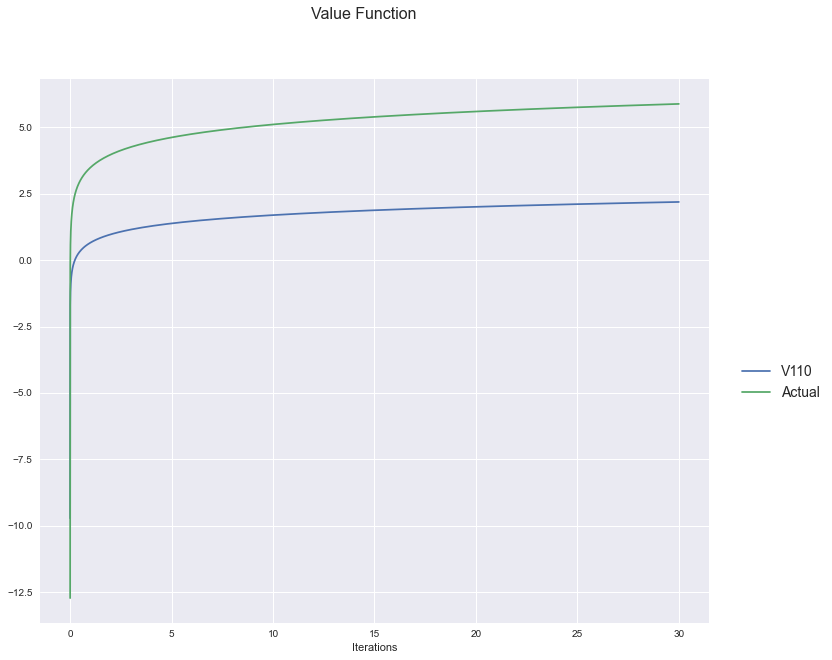

In [33]:
def Va(k, alpha=.45, beta=.8):
    ab = alpha*beta
    return E+Fcons*np.log(k)

V0 = LinInterp(grid,U(grid))
plt.figure(1, figsize=(12,10))
plt.plot(grid, V0(grid), label='V'+str(count))
plt.plot(grid, Va(grid), label='Actual')
plt.legend(loc=(1.04,0.4), fontsize=14)
plt.suptitle('Value Function')
plt.xlabel('Iterations')

In [34]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [35]:
# print((1-alpha*beta)*A*grid**alpha)  # Verificamos los valores del grid, ya que al estar cercanos a cero nos rompen la funcion recursiva algunos NaN values

<ipython-input-31-f2422ca72c0e>:11: RuntimeWarning: invalid value encountered in log
  h = lambda kp: np.log(kmax**alpha - kp) + beta * w(kp)  # Aquí cambiamos la expresion de la Bellman Equation


Text(0.5, 0, 'Iterations')

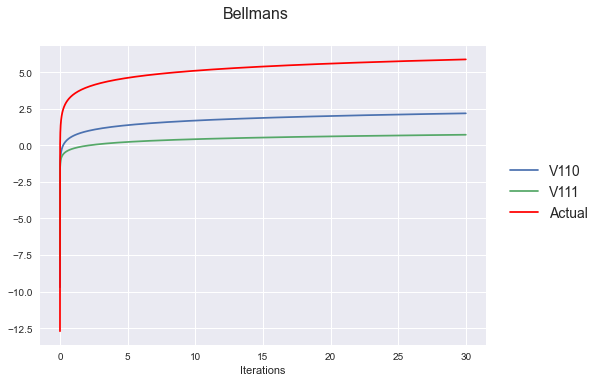

In [36]:
plt.plot(grid, V0(grid), label='V'+str(count));
count += 1
V0 = bellman(V0)
plt.figure(1, figsize=(12,10))
plt.plot(grid, V0(grid), label='V'+str(count));
plt.plot(grid, Va(grid), label='Actual',color='r');
plt.legend(loc=(1.04,0.4), fontsize=14)
plt.suptitle('Bellmans')
plt.xlabel('Iterations')

<ipython-input-31-f2422ca72c0e>:11: RuntimeWarning: invalid value encountered in log
  h = lambda kp: np.log(kmax**alpha - kp) + beta * w(kp)  # Aquí cambiamos la expresion de la Bellman Equation
<ipython-input-31-f2422ca72c0e>:11: RuntimeWarning: invalid value encountered in log
  h = lambda kp: np.log(kmax**alpha - kp) + beta * w(kp)  # Aquí cambiamos la expresion de la Bellman Equation
<ipython-input-31-f2422ca72c0e>:11: RuntimeWarning: invalid value encountered in log
  h = lambda kp: np.log(kmax**alpha - kp) + beta * w(kp)  # Aquí cambiamos la expresion de la Bellman Equation
<ipython-input-31-f2422ca72c0e>:11: RuntimeWarning: invalid value encountered in log
  h = lambda kp: np.log(kmax**alpha - kp) + beta * w(kp)  # Aquí cambiamos la expresion de la Bellman Equation
<ipython-input-31-f2422ca72c0e>:11: RuntimeWarning: invalid value encountered in log
  h = lambda kp: np.log(kmax**alpha - kp) + beta * w(kp)  # Aquí cambiamos la expresion de la Bellman Equation
<ipython-input-31-f2

60


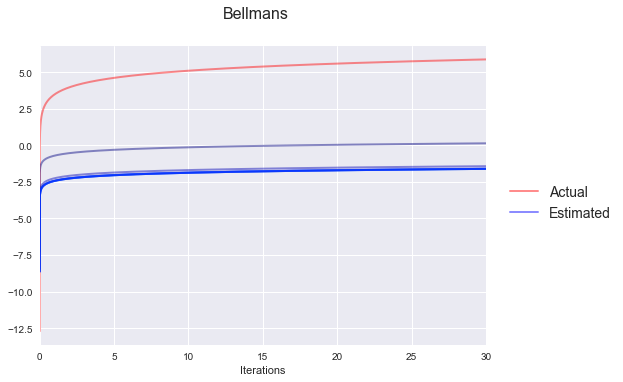

In [37]:
fig, ax = plt.subplots()
ax.set_xlim(grid.min(), grid.max())
ax.plot(grid, Va(grid), label='Actual', color='r', lw=2, alpha=0.45);

count=0
maxiter=200
tol=1e-6
while count<maxiter:
    V1 = bellman(V0)
    err = np.max(np.abs(np.array(V1(grid))-np.array(V0(grid))))
    if np.mod(count,10)==0:
        ax.plot(grid, V1(grid), color=plt.cm.jet(count / maxiter), lw=2, alpha=0.45);
        #print('%d %2.10f ' % (count,err))
    V0 = V1
    count += 1
    if err<tol:
        print(count)
        break
ax.plot(grid, V1(grid), label='Estimated', color='b', lw=2, alpha=0.45);
plt.legend(loc=(1.04,0.4), fontsize=14)
plt.suptitle('Bellmans')
plt.xlabel('Iterations')
plt.draw();

8.567594882435969e-07
11.562775060414006


Text(0.5, 0.98, 'Our Error Behavior')

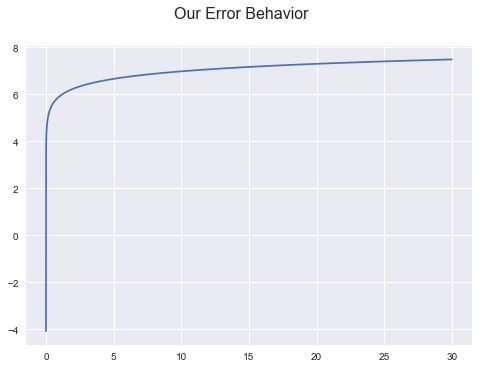

In [38]:
print(err)
err = Va(grid)-V1(grid)
plt.plot(grid,err);
print(err.max()-err.min())
plt.suptitle('Our Error Behavior')

Our error differs way too much from our first exercise.